# Week 6: Sankey Visualization Data Preprocessing

**Goal**: Process ACLED data to create actor-country-conflict type flows for Sankey visualization.

**Output**: `viz10_actor_sankey.json` with:
- Top 6 actors per actor type
- Aggregated flows: Actor → Country → Event Type
- Event counts and fatality statistics
- Timeline data hooks for future implementation

In [1]:
import pandas as pd
import numpy as np
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load and Explore ACLED Data

In [2]:
# Load ACLED data
print("Loading ACLED dataset...")
df = pd.read_csv('../raw-data/ACLED/ACLED_2025-10-29.csv')

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"Date range: {df['event_date'].min()} to {df['event_date'].max()}")

# Display basic info
df.info()

Loading ACLED dataset...
Dataset shape: (2372683, 35)
Memory usage: 4060.0 MB
Date range: 1997-01-29 to 2024-10-29
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372683 entries, 0 to 2372682
Data columns (total 35 columns):
 #   Column              Dtype  
---  ------              -----  
 0   event_id_cnty       object 
 1   event_date          object 
 2   year                int64  
 3   time_precision      int64  
 4   disorder_type       object 
 5   event_type          object 
 6   sub_event_type      object 
 7   actor1              object 
 8   assoc_actor_1       object 
 9   inter1              object 
 10  actor2              object 
 11  assoc_actor_2       object 
 12  inter2              object 
 13  interaction         object 
 14  civilian_targeting  object 
 15  iso                 int64  
 16  region              object 
 17  country             object 
 18  admin1              object 
 19  admin2              object 
 20  admin3              object 
 21  location

In [3]:
# Key columns for Sankey visualization
key_columns = ['actor1', 'inter1', 'country', 'event_type', 'sub_event_type', 
               'fatalities', 'year', 'event_date', 'event_id_cnty']

print("Key columns for analysis:")
for col in key_columns:
    if col in df.columns:
        print(f"✓ {col}: {df[col].dtype}, {df[col].isnull().sum()} nulls")
    else:
        print(f"✗ {col}: NOT FOUND")

# Sample data
print("\nSample data:")
df[key_columns].head()

Key columns for analysis:
✓ actor1: object, 0 nulls
✓ inter1: object, 0 nulls
✓ country: object, 0 nulls
✓ event_type: object, 0 nulls
✓ sub_event_type: object, 0 nulls
✓ fatalities: int64, 0 nulls
✓ year: int64, 0 nulls
✓ event_date: object, 0 nulls
✓ event_id_cnty: object, 0 nulls

Sample data:


,actor1,inter1,country,event_type,sub_event_type,fatalities,year,event_date,event_id_cnty
0,GIA: Armed Islamic Group,Rebel group,Algeria,Violence against civilians,Attack,8,1997,1997-01-29,ALG40
1,Kamajor Militia,Political militia,Sierra Leone,Strategic developments,Non-violent transfer of territory,0,1997,1997-01-29,SIE40
2,Rioters (Nigeria),Rioters,Nigeria,Riots,Mob violence,1,1997,1997-01-29,NIG14
3,SPLM/A: Sudan People's Liberation Movement/Army,Rebel group,Sudan,Battles,Armed clash,0,1997,1997-01-30,SUD55
4,GIA: Armed Islamic Group,Rebel group,Algeria,Violence against civilians,Attack,1,1997,1997-01-30,ALG41


## 2. Analyze Actor Types and Distribution

Actor Type Distribution (inter1):
inter1
Protesters               977270
State forces             381393
Political militia        323708
External/Other forces    270140
Rebel group              211649
Rioters                  158023
Identity militia          44704
Civilians                  5796
Name: count, dtype: int64


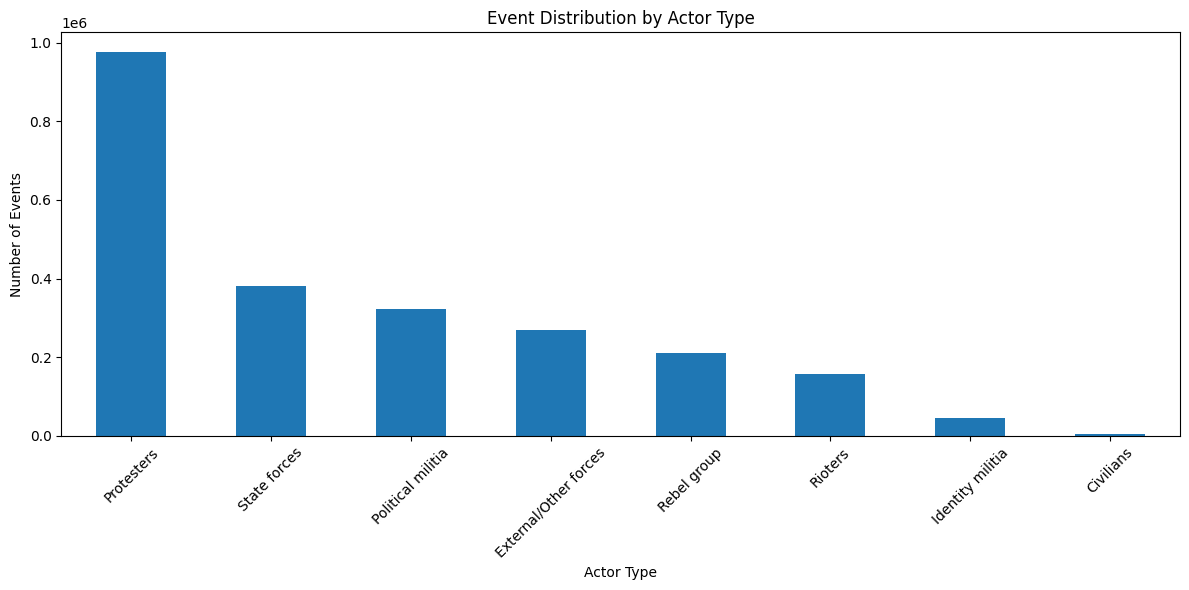

In [4]:
# Actor type distribution
print("Actor Type Distribution (inter1):")
actor_type_counts = df['inter1'].value_counts()
print(actor_type_counts)

# Visualize distribution
plt.figure(figsize=(12, 6))
actor_type_counts.plot(kind='bar')
plt.title('Event Distribution by Actor Type')
plt.xlabel('Actor Type')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Event Type Distribution:
event_type
Protests                      978071
Explosions/Remote violence    412327
Battles                       396931
Violence against civilians    272164
Riots                         159903
Strategic developments        153287
Name: count, dtype: int64


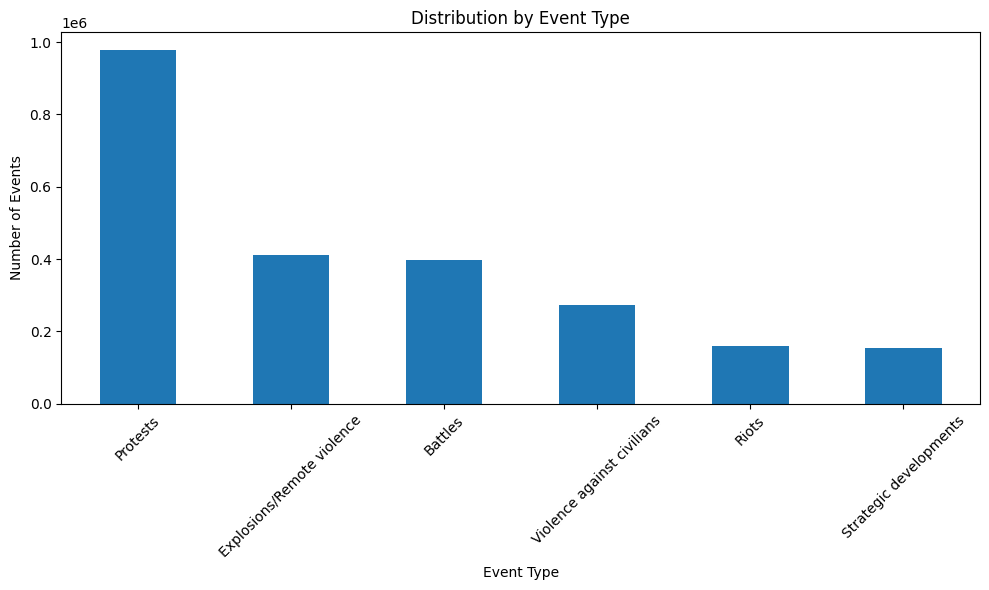

In [5]:
# Event type distribution
print("\nEvent Type Distribution:")
event_type_counts = df['event_type'].value_counts()
print(event_type_counts)

# Visualize
plt.figure(figsize=(10, 6))
event_type_counts.plot(kind='bar')
plt.title('Distribution by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Number of Events')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Identify Top 6 Actors per Actor Type

In [6]:
# Count events per actor within each actor type
actor_stats = df.groupby(['inter1', 'actor1']).agg({
    'event_id_cnty': 'count',
    'fatalities': 'sum',
    'country': 'nunique'
}).rename(columns={
    'event_id_cnty': 'total_events',
    'country': 'countries_active'
}).reset_index()

print(f"Total unique actors: {len(actor_stats)}")
print("\nTop actors overall:")
print(actor_stats.nlargest(10, 'total_events')[['actor1', 'inter1', 'total_events', 'fatalities']])

Total unique actors: 16073

Top actors overall:
                                     actor1                 inter1  \
12639                    Protesters (India)             Protesters   
356       Military Forces of Russia (2000-)  External/Other forces   
12699                 Protesters (Pakistan)             Protesters   
12762            Protesters (United States)             Protesters   
14815  Military Forces of Syria (2000-2024)           State forces   
12676                   Protesters (Mexico)             Protesters   
12737              Protesters (South Korea)             Protesters   
13679                               Taliban            Rebel group   
12618                   Protesters (France)             Protesters   
14895    Military Forces of Ukraine (2019-)           State forces   

       total_events  fatalities  
12639        129098         110  
356          106115       73386  
12699         72901          78  
12762         67711           8  
14815      

In [7]:
# Get top 6 actors per actor type
top_actors_by_type = {}

for actor_type in actor_stats['inter1'].unique():
    if pd.isna(actor_type):
        continue
    
    type_actors = actor_stats[actor_stats['inter1'] == actor_type].nlargest(6, 'total_events')
    top_actors_by_type[actor_type] = type_actors['actor1'].tolist()
    
    print(f"\n{actor_type} - Top 6 Actors:")
    for i, (_, row) in enumerate(type_actors.iterrows(), 1):
        print(f"{i}. {row['actor1'][:60]:<60} | {row['total_events']:>6} events | {row['fatalities']:>7} fatalities")

# Summary
total_selected_actors = sum(len(actors) for actors in top_actors_by_type.values())
print(f"\nTotal selected actors: {total_selected_actors}")
print(f"Actor types: {list(top_actors_by_type.keys())}")


Civilians - Top 6 Actors:
1. Civilians (Myanmar)                                          |   1492 events |       1 fatalities
2. Civilians (Ukraine)                                          |    742 events |       0 fatalities
3. Civilians (Colombia)                                         |    730 events |       0 fatalities
4. Civilians (Syria)                                            |    498 events |       0 fatalities
5. Civilians (Democratic Republic of Congo)                     |    286 events |       1 fatalities
6. Civilians (Haiti)                                            |    242 events |       0 fatalities

External/Other forces - Top 6 Actors:
1. Military Forces of Russia (2000-)                            | 106115 events |   73386 fatalities
2. Military Forces of Israel (2022-)                            |  27862 events |   44496 fatalities
3. Operation Restoring Hope                                     |  25815 events |   25204 fatalities
4. Military Forces of Tur

## 4. Filter Data and Create Flows

In [8]:
# Create list of all selected actors
all_selected_actors = []
for actor_list in top_actors_by_type.values():
    all_selected_actors.extend(actor_list)

print(f"Filtering data for {len(all_selected_actors)} selected actors...")

# Filter dataset to only selected actors
df_filtered = df[df['actor1'].isin(all_selected_actors)].copy()

print(f"Original dataset: {len(df):,} events")
print(f"Filtered dataset: {len(df_filtered):,} events ({len(df_filtered)/len(df)*100:.1f}% of original)")

# Check data quality
print("\nData quality check:")
print(f"Missing actor1: {df_filtered['actor1'].isnull().sum()}")
print(f"Missing country: {df_filtered['country'].isnull().sum()}")
print(f"Missing event_type: {df_filtered['event_type'].isnull().sum()}")
print(f"Missing fatalities: {df_filtered['fatalities'].isnull().sum()}")

Filtering data for 48 selected actors...
Original dataset: 2,372,683 events
Filtered dataset: 1,050,969 events (44.3% of original)

Data quality check:
Missing actor1: 0
Missing country: 0
Missing event_type: 0
Missing fatalities: 0


In [9]:
# Clean data - fill missing fatalities with 0
df_filtered['fatalities'] = df_filtered['fatalities'].fillna(0)

# Remove rows with missing essential data
essential_columns = ['actor1', 'inter1', 'country', 'event_type']
df_clean = df_filtered.dropna(subset=essential_columns)

print(f"After cleaning: {len(df_clean):,} events ({len(df_clean)/len(df_filtered)*100:.1f}% retained)")

# Convert year to int
df_clean['year'] = df_clean['year'].astype(int)

print(f"Year range: {df_clean['year'].min()} - {df_clean['year'].max()}")

After cleaning: 1,050,969 events (100.0% retained)
Year range: 1997 - 2024


## 5. Aggregate Flows by Actor-Country-Event Type

In [10]:
# Create flows: Actor → Country → Event Type
print("Aggregating flows...")

flows = df_clean.groupby(['actor1', 'inter1', 'country', 'event_type']).agg({
    'event_id_cnty': 'count',
    'fatalities': 'sum', 
    'year': lambda x: sorted(x.unique()),
    'sub_event_type': lambda x: x.mode().iloc[0] if not x.empty else 'Unknown'
}).rename(columns={
    'event_id_cnty': 'events'
}).reset_index()

print(f"Total flows created: {len(flows)}")
print(f"Unique actors: {flows['actor1'].nunique()}")
print(f"Unique countries: {flows['country'].nunique()}")
print(f"Unique event types: {flows['event_type'].nunique()}")

# Display sample flows
print("\nSample flows:")
flows.head(10)

Aggregating flows...
Total flows created: 471
Unique actors: 48
Unique countries: 115
Unique event types: 6

Sample flows:


,actor1,inter1,country,event_type,events,fatalities,year,sub_event_type
0,Al Shabaab,Rebel group,Djibouti,Explosions/Remote violence,1,3,[2014],Suicide bomb
1,Al Shabaab,Rebel group,Ethiopia,Battles,3,26,"[2013, 2014, 2022]",Armed clash
2,Al Shabaab,Rebel group,Ethiopia,Strategic developments,1,2,[2013],Disrupted weapons use
3,Al Shabaab,Rebel group,Kenya,Battles,264,444,"[2008, 2009, 2010, 2011, 2012, 2013, 2017, 201...",Armed clash
4,Al Shabaab,Rebel group,Kenya,Explosions/Remote violence,194,531,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...",Remote explosive/landmine/IED
5,Al Shabaab,Rebel group,Kenya,Strategic developments,88,31,"[2010, 2011, 2012, 2013, 2014, 2015, 2016, 201...",Looting/property destruction
6,Al Shabaab,Rebel group,Kenya,Violence against civilians,179,679,"[2009, 2010, 2011, 2012, 2013, 2014, 2015, 201...",Attack
7,Al Shabaab,Rebel group,Somalia,Battles,9522,14189,"[2006, 2007, 2008, 2009, 2010, 2011, 2012, 201...",Armed clash
8,Al Shabaab,Rebel group,Somalia,Explosions/Remote violence,3762,7723,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 201...",Remote explosive/landmine/IED
9,Al Shabaab,Rebel group,Somalia,Protests,1,0,[2013],Excessive force against protesters


In [11]:
# Create year-by-year breakdown for timeline hooks
print("Creating year-by-year breakdown...")

year_breakdown = df_clean.groupby(['actor1', 'inter1', 'country', 'event_type', 'year']).agg({
    'event_id_cnty': 'count',
    'fatalities': 'sum'
}).rename(columns={'event_id_cnty': 'events'}).reset_index()

print(f"Year-breakdown records: {len(year_breakdown)}")
print("Sample year breakdown:")
year_breakdown.head()

Creating year-by-year breakdown...
Year-breakdown records: 1815
Sample year breakdown:


,actor1,inter1,country,event_type,year,events,fatalities
0,Al Shabaab,Rebel group,Djibouti,Explosions/Remote violence,2014,1,3
1,Al Shabaab,Rebel group,Ethiopia,Battles,2013,1,0
2,Al Shabaab,Rebel group,Ethiopia,Battles,2014,1,0
3,Al Shabaab,Rebel group,Ethiopia,Battles,2022,1,26
4,Al Shabaab,Rebel group,Ethiopia,Strategic developments,2013,1,2


## 6. Calculate Statistics for Color Coding

In [12]:
# Fatality statistics for color scaling
fatality_stats = {
    'min': int(flows['fatalities'].min()),
    'max': int(flows['fatalities'].max()),
    'mean': float(flows['fatalities'].mean()),
    'median': float(flows['fatalities'].median()),
    'q25': float(flows['fatalities'].quantile(0.25)),
    'q75': float(flows['fatalities'].quantile(0.75))
}

print("Fatality Statistics:")
for key, value in fatality_stats.items():
    print(f"{key}: {value:,.1f}")

# Event count statistics
event_stats = {
    'min': int(flows['events'].min()),
    'max': int(flows['events'].max()),
    'mean': float(flows['events'].mean()),
    'median': float(flows['events'].median())
}

print("\nEvent Count Statistics:")
for key, value in event_stats.items():
    print(f"{key}: {value:,.1f}")

Fatality Statistics:
min: 0.0
max: 79,276.0
mean: 1,582.1
median: 1.0
q25: 0.0
q75: 69.5

Event Count Statistics:
min: 1.0
max: 129,002.0
mean: 2,231.4
median: 7.0


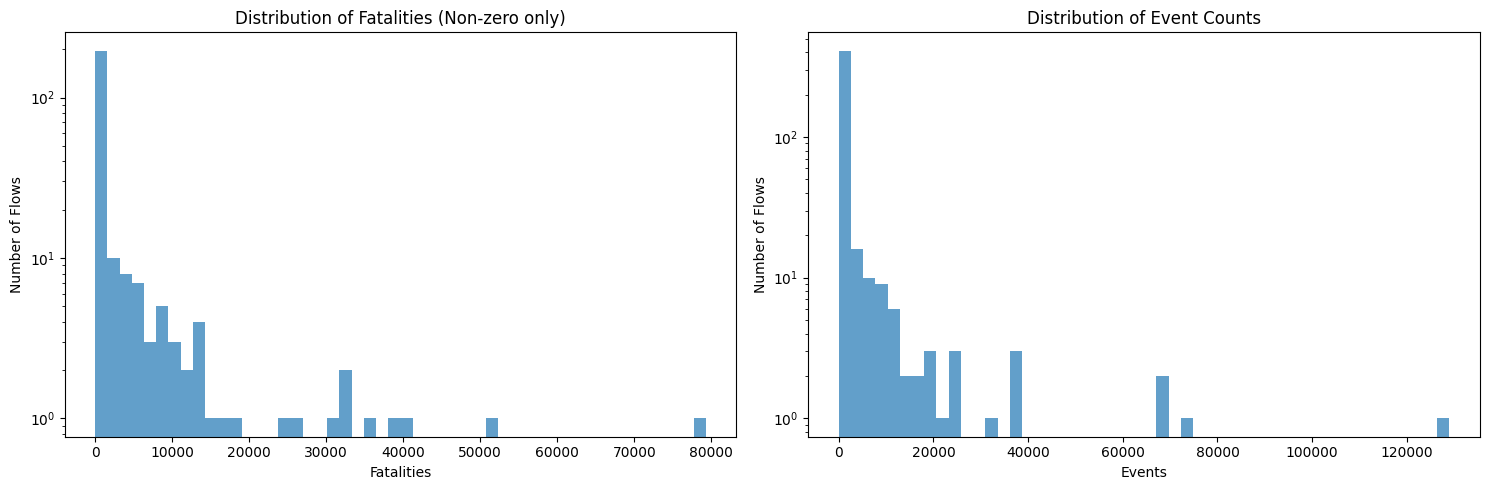

Flows with zero fatalities: 220 / 471 (46.7%)


In [13]:
# Visualize distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Fatalities distribution (log scale)
flows_nonzero_fatalities = flows[flows['fatalities'] > 0]
ax1.hist(flows_nonzero_fatalities['fatalities'], bins=50, alpha=0.7)
ax1.set_xlabel('Fatalities')
ax1.set_ylabel('Number of Flows')
ax1.set_title('Distribution of Fatalities (Non-zero only)')
ax1.set_yscale('log')

# Events distribution
ax2.hist(flows['events'], bins=50, alpha=0.7)
ax2.set_xlabel('Events')
ax2.set_ylabel('Number of Flows')
ax2.set_title('Distribution of Event Counts')
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"Flows with zero fatalities: {(flows['fatalities'] == 0).sum()} / {len(flows)} ({(flows['fatalities'] == 0).mean()*100:.1f}%)")

## 7. Prepare Final Dataset Structure

In [14]:
# Create year breakdown lookup dictionary (more robust approach)
# Build a dictionary keyed by (actor, actor_type, country, event_type) -> year data
print("Building year breakdown lookup...")

year_breakdown_lookup = {}
for _, row in year_breakdown.iterrows():
    key = (row['actor1'], row['inter1'], row['country'], row['event_type'])
    if key not in year_breakdown_lookup:
        year_breakdown_lookup[key] = {}
    year_breakdown_lookup[key][str(int(row['year']))] = {
        'events': int(row['events']),
        'fatalities': int(row['fatalities'])
    }

print(f"Created lookup with {len(year_breakdown_lookup)} unique flow keys")

# Test lookup
sample_key = list(year_breakdown_lookup.keys())[0]
print(f"\nSample lookup for {sample_key}:")
print(year_breakdown_lookup[sample_key])

Building year breakdown lookup...
Created lookup with 471 unique flow keys

Sample lookup for ('Al Shabaab', 'Rebel group', 'Djibouti', 'Explosions/Remote violence'):
{'2014': {'events': 1, 'fatalities': 3}}


In [15]:
# Create final dataset structure
print("Building final dataset structure...")

# Calculate statistics
fatality_stats = {
    'min': int(flows['fatalities'].min()),
    'max': int(flows['fatalities'].max()),
    'mean': float(flows['fatalities'].mean()),
    'median': float(flows['fatalities'].median()),
    'q25': float(flows['fatalities'].quantile(0.25)),
    'q75': float(flows['fatalities'].quantile(0.75))
}

event_stats = {
    'min': int(flows['events'].min()),
    'max': int(flows['events'].max()),
    'mean': float(flows['events'].mean()),
    'median': float(flows['events'].median())
}

# Convert flows to final format with year_breakdown from lookup
flows_list = []
missing_year_breakdown = 0

for _, row in flows.iterrows():
    # Get year breakdown from lookup dictionary
    key = (row['actor1'], row['inter1'], row['country'], row['event_type'])
    year_breakdown_dict = year_breakdown_lookup.get(key, {})
    
    if not year_breakdown_dict:
        missing_year_breakdown += 1
    
    flow_dict = {
        'actor': row['actor1'],
        'actor_type': row['inter1'],
        'country': row['country'],
        'event_type': row['event_type'],
        'sub_event_type': row['sub_event_type'],  # Added sub_event_type
        'events': int(row['events']),
        'fatalities': int(row['fatalities']),
        'years': [int(y) for y in row['year']],
        'year_breakdown': year_breakdown_dict
    }
    
    flows_list.append(flow_dict)

print(f"Created {len(flows_list)} flow records")
print(f"Flows missing year_breakdown: {missing_year_breakdown}")

# Verify year_breakdown is populated
populated = sum(1 for f in flows_list if f['year_breakdown'])
print(f"Flows with populated year_breakdown: {populated}/{len(flows_list)}")

# Create final dataset
final_dataset = {
    'metadata': {
        'created_date': datetime.now().isoformat(),
        'source': 'ACLED_2025-10-29.csv',
        'total_actors': len(all_selected_actors),
        'total_flows': len(flows_list),
        'year_range': [int(df_clean['year'].min()), int(df_clean['year'].max())],
        'fatality_stats': fatality_stats,
        'event_stats': event_stats
    },
    'actor_types': top_actors_by_type,
    'flows': flows_list
}

print("\nFinal dataset structure:")
print(f"- Metadata: {len(final_dataset['metadata'])} fields")
print(f"- Actor types: {len(final_dataset['actor_types'])} categories")
print(f"- Flows: {len(final_dataset['flows'])} records")

# Show sample flow with year_breakdown
print("\nSample flow with year_breakdown:")
sample_with_data = next((f for f in flows_list if f['year_breakdown']), None)
if sample_with_data:
    print(json.dumps(sample_with_data, indent=2))

Building final dataset structure...
Created 471 flow records
Flows missing year_breakdown: 0
Flows with populated year_breakdown: 471/471

Final dataset structure:
- Metadata: 7 fields
- Actor types: 8 categories
- Flows: 471 records

Sample flow with year_breakdown:
{
  "actor": "Al Shabaab",
  "actor_type": "Rebel group",
  "country": "Djibouti",
  "event_type": "Explosions/Remote violence",
  "sub_event_type": "Suicide bomb",
  "events": 1,
  "fatalities": 3,
  "years": [
    2014
  ],
  "year_breakdown": {
    "2014": {
      "events": 1,
      "fatalities": 3
    }
  }
}


## 8. Export to JSON

In [16]:
# Export to JSON file
output_file = '../viz-datasets/viz10_actor_sankey.json'

print(f"Exporting to {output_file}...")

with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(final_dataset, f, indent=2, ensure_ascii=False)

# Check file size
import os
file_size = os.path.getsize(output_file) / 1024**2
print(f"File exported successfully!")
print(f"File size: {file_size:.1f} MB")

# Test loading
with open(output_file, 'r', encoding='utf-8') as f:
    test_load = json.load(f)

print(f"\nVerification - loaded {len(test_load['flows'])} flows")
print(f"Sample flow keys: {list(test_load['flows'][0].keys())}")

Exporting to ../viz-datasets/viz10_actor_sankey.json...
File exported successfully!
File size: 0.3 MB

Verification - loaded 471 flows
Sample flow keys: ['actor', 'actor_type', 'country', 'event_type', 'sub_event_type', 'events', 'fatalities', 'years', 'year_breakdown']


## 9. Summary and Next Steps

In [17]:
# Final summary
print("=== DATA PREPROCESSING COMPLETE ===")
print(f"\nOriginal dataset: {len(df):,} events")
print(f"Processed flows: {len(flows_list):,}")
print(f"Selected actors: {len(all_selected_actors)}")
print(f"Actor types: {len(top_actors_by_type)}")

print("\nActor type breakdown:")
for actor_type, actors in top_actors_by_type.items():
    print(f"- {actor_type}: {len(actors)} actors")

print(f"\nOutput file: {output_file}")
print(f"File size: {file_size:.1f} MB")

print("\n=== READY FOR PHASE 2: SANKEY IMPLEMENTATION ===")
print("Next steps:")
print("1. Copy JSON to public/src/assets/data/")
print("2. Update SankeyChart.vue with actor dropdown")
print("3. Implement 3-level sankey visualization")
print("4. Add fatality-based color coding")

=== DATA PREPROCESSING COMPLETE ===

Original dataset: 2,372,683 events
Processed flows: 471
Selected actors: 48
Actor types: 8

Actor type breakdown:
- Civilians: 6 actors
- External/Other forces: 6 actors
- Identity militia: 6 actors
- Political militia: 6 actors
- Protesters: 6 actors
- Rebel group: 6 actors
- Rioters: 6 actors
- State forces: 6 actors

Output file: ../viz-datasets/viz10_actor_sankey.json
File size: 0.3 MB

=== READY FOR PHASE 2: SANKEY IMPLEMENTATION ===
Next steps:
1. Copy JSON to public/src/assets/data/
2. Update SankeyChart.vue with actor dropdown
3. Implement 3-level sankey visualization
4. Add fatality-based color coding


# Network